<a href="https://colab.research.google.com/github/zahraDehghanian97/SCINet/blob/master/arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocess**

In [1]:
import pandas as pd
df = pd.read_csv('/content/MCIRD_aaic2021_train.csv', header=0)
df.head()


,day,subscriber_ecid,subscriber_gender,subscriber_age,registration_province,months_of_subscription,most_used_province,is_usage_nonzero,subscriber_total_expenses,nonpackage_voice_expenses,package_voice_noncash_expenses,is_voice_expenses_nonzero,is_voice_usage_nonzero,call_in_network_duration,call_off_netwrok_duration,nonpackage_call_in_network_expenses,nonpackage_call_off_network_expenses,total_call_duration,#inter_operator_calls,xyz_score,hxr_score,data_cash_expenses,nonpackage_data_expenses,package_data_noncash_expenses,subscriber_data_expenses,subscriber_nondata_expenses,data_usage_volume,is_data_expenses_nonzero,is_data_usage_nonzero,#activated_monthly_data_packages,#activated_short_term_data_packages,#activated_type_one_data_packages,#activated_type_two_data_packages,#activated_type_three_data_packages
0,(n)01,-06FoayTOXJ8-,1,36.0,8,188,8,1,-0.132373,-0.072802,0.0,1,1,-0.155626,0.0,-0.256454,0.0,-0.220797,0.0,0.031219,38.192862,0.0,0.0,0.0,0.0,-0.104687,0.072258,0,1,0,0,0,0,0
1,(n)02,-06FoayTOXJ8-,1,36.0,8,188,8,1,-0.122445,-0.060440,0.0,1,1,-0.142857,0.0,0.036145,0.0,-0.210668,0.0,0.033491,38.144232,0.0,0.0,0.0,0.0,-0.092861,0.049563,0,1,0,0,0,0,0
2,(n)03,-06FoayTOXJ8-,1,36.0,8,188,8,1,0.343066,0.519231,0.0,1,1,0.418196,0.0,0.762478,0.0,0.264686,0.0,0.036831,37.990377,0.0,0.0,0.0,0.0,0.461665,-0.013977,0,0,0,0,0,0,0
3,(n)04,-06FoayTOXJ8-,1,36.0,8,188,8,1,1.869763,2.420329,0.0,1,1,2.259377,0.0,3.144579,0.0,1.821742,0.0,0.039942,37.777398,0.0,0.0,0.0,0.0,2.280301,0.000403,0,1,0,0,0,0,0
4,(n)05,-06FoayTOXJ8-,1,36.0,8,188,8,1,-0.233858,-0.199176,0.0,1,1,-0.277733,0.0,-0.137693,0.0,-0.324105,0.0,0.042694,37.545275,0.0,0.0,0.0,0.0,-0.225579,0.016209,0,1,0,0,0,0,0


In [2]:
df1 = df[['subscriber_ecid', 'data_usage_volume']]
df1.head()

,subscriber_ecid,data_usage_volume
0,-06FoayTOXJ8-,0.072258
1,-06FoayTOXJ8-,0.049563
2,-06FoayTOXJ8-,-0.013977
3,-06FoayTOXJ8-,0.000403
4,-06FoayTOXJ8-,0.016209


خیلی از مقادیر دیتاست -0.0139766307813943 این هستن و میشه به راحتی اینارو جایگزین کرد

In [3]:
unique_sub_id = set(df1['subscriber_ecid'].values)

In [4]:
len(unique_sub_id)

100

use just sample with 69 element

In [5]:
import numpy as np
data_list = []
for sub_id in unique_sub_id:
    # print(sub_id)
    temp = df1[df1['subscriber_ecid']==sub_id].values
    if temp.shape[0] < 69:
        print(temp.shape)
        print(sub_id)
    else:
        data_list.append(temp)

(67, 2)
-XU6p4P-782mp
(53, 2)
0T7ixhiDdZ8TL
(1, 2)
37v4v4PPObMC_
(61, 2)
0o-xDa8uTNBGu
(60, 2)
-QXHomYaJxYXi
(2, 2)
28gWxNYMU_2dg
(22, 2)
-gjfIaG2oxwzj
(68, 2)
-DgEYYT0gqMqr
(18, 2)
1EN04BS-9nKgc
(1, 2)
32ez6CX89v6KZ


data plot

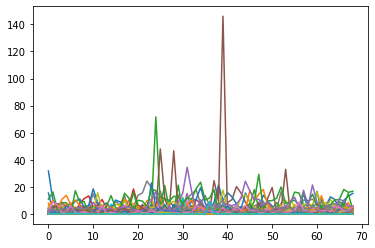

In [6]:
import matplotlib.pyplot as plt
for j in range(len(data_list)) :
  one_sample = data_list[j]
  y = one_sample[:,1]
  x = []

  for i in range(len(one_sample[:,1])):
    x.append(i)
  plt.plot(x,y)

plt.show()

# **ARIMA model**

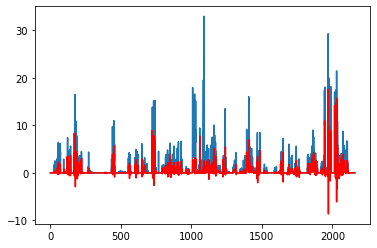

Test RMSE: 2.590
2.5902000928583044
best updated!
ARIMA(0, 0, 1) RMSE=2.590


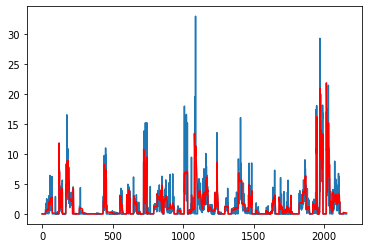

Test RMSE: 2.035
2.0350030065527913
best updated!
ARIMA(0, 1, 1) RMSE=2.035


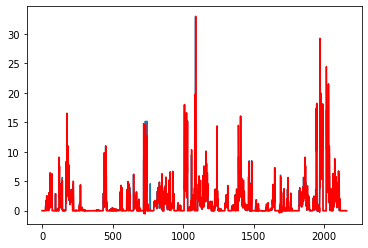

Test RMSE: 2.411
2.4110433060430694
ARIMA(0, 2, 1) RMSE=2.411


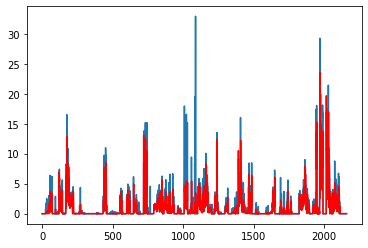

Test RMSE: 2.222
2.221669237021542
ARIMA(1, 0, 0) RMSE=2.222


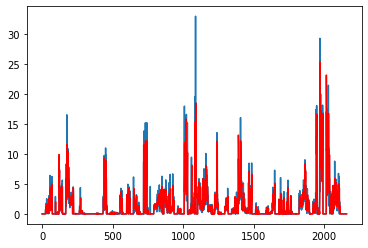

Test RMSE: 2.209
2.2090159681599557
ARIMA(1, 1, 0) RMSE=2.209


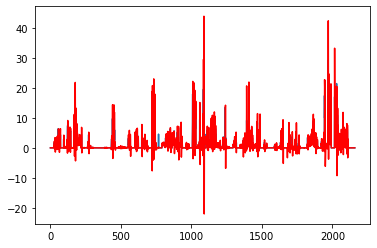

Test RMSE: 3.244
3.243658454926183
ARIMA(1, 2, 0) RMSE=3.244


Best ARIMA(0, 1, 1) RMSE=2.035


In [21]:
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas import DataFrame
import warnings
from math import sqrt

def evaluate_arima_model(arima_order):
  final_test = []
  final_predict = []
  # split into train and test sets
  for j in range(len(data_list)):
    X = data_list[j]
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    train =(train[:,1])
    test = list(test[:,1]+0.00001*np.random.rand(len(test)))
    history =list(train+0.00001*np.random.rand(len(train)))
    predictions = list()
    # model fit
    for t in range(len(test)):
      model = ARIMA(history, order=arima_order)
      model_fit = model.fit(trend='nc', disp=1)
      output = model_fit.forecast()
      yhat = output[0]
      predictions.append(yhat)
      obs = test[t]
      history.append(obs)
      # print('predicted=%f, expected=%f' % (yhat, obs))
    final_test.extend(test)
    final_predict.extend(predictions)
  pyplot.plot(final_test)
  pyplot.plot(final_predict, color='red')
  pyplot.show()
  # evaluate forecasts
  rmse = sqrt(mean_squared_error(np.array(final_test), np.array(final_predict)))
  print('Test RMSE: %.3f' % rmse)
  return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models( p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                
                try:
                    rmse = evaluate_arima_model(order)
                    print(rmse)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print("best updated!")
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except Exception as e: 
                #     print(e)
                    # print("error catch in ARIMA",order)
                    continue

    print('\n==============================\n')
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

best_order = evaluate_models( p_values, d_values, q_values)


get result

In [26]:
import numpy as np
all_data_list = []
for sub_id in unique_sub_id:
    temp = df1[df1['subscriber_ecid']==sub_id].values
    if temp.shape[0] >2:
      all_data_list.append(temp)

final_predict_all_data = []
# split into train and test sets
for j in range(len(all_data_list)):
  X = all_data_list[j]
  train =(X[:,1])
  history =list(train+0.00001*np.random.rand(len(train)))
  predictions = list()
  # model fit
  for t in range(7):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit(trend='nc', disp=1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    history.append(yhat[0])
    # print('predicted=%f, expected=%f' % (yhat, obs))
  final_predict_all_data.append(predictions)
print("======= final result =======")
print(final_predict_all_data)

======= final result =======
[[-0.013972029929192938, -0.013971986237108654, -0.013971986861275156, -0.013971986852484205, -0.013971986852606305, -0.01397198685260463, -0.013971986852604654], [0.6135033577379765, 0.6134295145328961, 0.613363504414393, 0.6133021761865829, 0.6132451635788722, 0.6131921941834754, 0.6131429883375895], [3.007749624798927, 3.006699411577495, 3.0058193171087337, 3.005076440073078, 3.0044456884386235, 3.003907787057643, 3.003447389629407], [0.11909277367029968, 0.1171665311733874, 0.11719409706644376, 0.11719371852130764, 0.1171937582570557, 0.11719409021387114, 0.11719359875922215], [0.011025922822549042, 0.011110175124036009, 0.011169259659990216, 0.01121235759511175, 0.011244487182461118, 0.011268805372308285, 0.011287373697381822], [5.013943149644384, 5.013734455621578, 5.013667699852145, 5.013646274925696, 5.013639346153804, 5.013637113115996, 5.013636390219261], [0.010877152106326806, 0.01088036703527456, 0.010882446206123107, 0.010883793614775046, 0.010

# **LSTM Model**

In [ ]:
X = []
y = []
mem_step = 14

for item in data_list:
  for i in range(mem_step, 69):
      X.append(item[i-mem_step:i, 1:2])
      # print(item[i-mem_step:i, 1:2])
      y.append(item[i, 1:2])

X, y = np.array(X), np.array(y)
X, y = X.astype('float32'), y.astype('float32')

In [ ]:
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# check GPU availability
print("GPU is available :)" if tf.config.list_physical_devices("GPU") else "Not available :(")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
keras_reg = Sequential()

keras_reg.add(LSTM(units = 64, return_sequences = True, input_shape = (X.shape[1], 1)))
keras_reg.add(Dropout(0.4))

keras_reg.add(LSTM(units = 100, return_sequences = True))
keras_reg.add(Dropout(0.4))

keras_reg.add(LSTM(units = 100, return_sequences = True))
keras_reg.add(Dropout(0.2))

keras_reg.add(LSTM(units = 100, return_sequences = True))
keras_reg.add(Dropout(0.2))

keras_reg.add(LSTM(units = 16))
keras_reg.add(Dropout(0.2))

# keras_reg.add(Dense(units=32, activation='relu' ))
keras_reg.add(Dense(units=16, activation='relu' ))
keras_reg.add(Dense(units = 1))
keras_reg.compile(optimizer = 'adam',
                  loss = 'mean_squared_error',
                  metrics='mse')
# keras_reg.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history = keras_reg.fit(X_train, y_train,validation_split=0.2,shuffle=False,epochs = 30,verbose = 1)

In [ ]:
def plot_loss(history):
  fig = plt.figure(figsize=(7,7))
  plt.plot(history.history['mse'], label='mse')
  plt.plot(history.history['val_mse'], label='val_mse')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

predicted_stock_price = keras_reg.predict(X_test)
from sklearn.metrics import mean_squared_error
print(sqrt(mean_squared_error(y_test, predicted_stock_price)))